In [1]:
# setup
import gc
from typing import Tuple, Optional
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import seaborn as sns

# TODO: change the file path
FILE_DIR = "./nsynth-subtrain/audio"
LABEL_PATH = "./nsynth-subtrain/examples.json"
VAL_FILE_DIR = "./nsynth-valid/audio"
VAL_LABEL_PATH = "./nsynth-valid/examples.json"
RANDOM_SEED = 0
LABEL_NAMES = {0: "bass", 1: "brass", 2: "flute", 3: "guitar", 4: "keyboard", 5: "mallet", 6: "organ", 7: "reed", 8: "string", 9: "synth_lead", 10: "vocal"}


## Task2: Traditional ML Model

In [2]:
# load file
df = pd.read_json(LABEL_PATH, orient='index')
print(df.columns)
display(df.head())

# load valid file
val_df = pd.read_json(VAL_LABEL_PATH, orient='index')
print(val_df.columns)


Index(['note', 'sample_rate', 'pitch', 'instrument_source',
       'instrument_family_str', 'instrument_str', 'note_str', 'qualities_str',
       'instrument_source_str', 'velocity', 'instrument_family', 'instrument',
       'qualities'],
      dtype='object')


,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_022-108-127,89262,16000,108,2,bass,bass_synthetic_022,bass_synthetic_022-108-127,"[bright, distortion]",synthetic,127,0,321,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_050-108-075,272731,16000,108,2,bass,bass_synthetic_050,bass_synthetic_050-108-075,"[distortion, nonlinear_env]",synthetic,75,0,540,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
bass_synthetic_057-108-100,284902,16000,108,2,bass,bass_synthetic_057,bass_synthetic_057-108-100,"[distortion, nonlinear_env]",synthetic,100,0,583,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
bass_synthetic_017-108-050,37332,16000,108,2,bass,bass_synthetic_017,bass_synthetic_017-108-050,[long_release],synthetic,50,0,249,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
bass_synthetic_131-108-100,225176,16000,108,2,bass,bass_synthetic_131,bass_synthetic_131-108-100,"[bright, distortion]",synthetic,100,0,909,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


Index(['note_str', 'sample_rate', 'qualities_str', 'instrument_source',
       'instrument_family_str', 'instrument_family', 'note',
       'instrument_source_str', 'qualities', 'pitch', 'instrument_str',
       'instrument', 'velocity'],
      dtype='object')


## Task2: Traditional ML Model

### Load data

In [3]:
# load files
mel_spectrograms = []
transform = MelSpectrogram(n_fft=2048, hop_length=512, sample_rate=16000)
to_db = AmplitudeToDB()
for filename in tqdm(df.index):
    filepath = f"{FILE_DIR}/{filename}.wav"
    wav, sr = torchaudio.load(filepath, normalize=True)
    mel_spec = to_db(transform(wav)).numpy()
    mel_spectrograms.append(mel_spec)

wavs = np.concatenate(mel_spectrograms, axis=0)
del mel_spectrograms
gc.collect()

print(wavs.shape)


100%|██████████| 48037/48037 [00:40<00:00, 1197.03it/s]


(48037, 128, 126)


In [4]:
# load valid files
val_mel_spectrograms = []
for filename in tqdm(val_df.index):
    filepath = f"{VAL_FILE_DIR}/{filename}.wav"
    wav, sr = torchaudio.load(filepath, normalize=True)
    mel_spec = to_db(transform(wav)).numpy()
    val_mel_spectrograms.append(mel_spec)

val_wavs = np.concatenate(val_mel_spectrograms, axis=0)
del val_mel_spectrograms
gc.collect()

print(val_wavs.shape)


100%|██████████| 12678/12678 [00:10<00:00, 1159.83it/s]


(12678, 128, 126)


### Feature Engineering
- `model_1`, `model_2`: processed wave (mean, max) + metadata

In [5]:
def get_features(wavs: np.array, df: pd.DataFrame, pooling: str, metadata: bool = True) -> Tuple[np.array, np.array]:
    if pooling == 'mean':
        # mean pooling across time and normalized
        wavs = wavs.mean(axis=2)
    elif pooling == 'max':
        # max pooling across time and normalized
        wavs = wavs.max(axis=2)
    else:
        raise NotImplementedError('Only mean and max pooling are implemented.')

    wavs = normalize(wavs, norm='l2')

    if metadata:
        # hand-craft features: ["note",	"pitch", "velocity", "qualities"]
        x_qual = np.array(df["qualities"].apply(lambda x: np.array(x)).tolist())
        x_npv = df[["note",	"pitch", "velocity"]].values
        x_feat = np.hstack((x_qual, x_npv))
        X_train = np.hstack((wavs, x_feat))
    else:
        X_train = wavs
    y_train = df["instrument_family"].values
    print(f"X shape: {X_train.shape}, y shape: {y_train.shape}")

    return X_train, y_train

X_train1, y_train = get_features(wavs, df, 'mean')
X_train2, y_train = get_features(wavs, df, 'max')
X_valid1, y_valid = get_features(val_wavs, val_df, 'mean')
X_valid2, y_valid = get_features(val_wavs, val_df, 'max')

X shape: (48037, 141), y shape: (48037,)
X shape: (48037, 141), y shape: (48037,)
X shape: (12678, 141), y shape: (12678,)
X shape: (12678, 141), y shape: (12678,)


### Train ML model (RandomForestClassifier)

In [6]:
def train_and_evaluate(X_train: np.array, y_train: np.array, model_path: str = None, params: Optional[dict] = None, random_state: int = RANDOM_SEED, verbose=False):
    
    if params:
        model = RandomForestClassifier(**params)
    else:
        model = RandomForestClassifier(n_estimators=100, random_state=random_state)
    model.fit(X_train, y_train)

    # evaluate training
    y_train_pred = model.predict(X_train)
    y_train_pred_p = model.predict_proba(X_train)
    train_top1_acc = accuracy_score(y_train, y_train_pred)
    train_top3_acc = top_k_accuracy_score(y_train, y_train_pred_p, k=3, labels=list(LABEL_NAMES.keys()))
    print(f"[Train] Top 1 Accuracy: {train_top1_acc:.4f}")
    print(f"[Train] Top 3 Accuracy: {train_top3_acc:.4f}")
    print("-----"*3)

    # Confusion Matrix
    if verbose:
        cmx = confusion_matrix(y_train, y_train_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cmx, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_NAMES.values(), yticklabels=LABEL_NAMES.values())
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    # save model
    if model_path:
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
    
    return model

def test(X_test: np.array, y_test: np.array, model: RandomForestClassifier, verbose: bool = True) -> float:
    # model testing
    y_pred = model.predict(X_test)
    y_pred_p = model.predict_proba(X_test)

    # Accuracy
    top1_acc = accuracy_score(y_test, y_pred)
    top3_acc = top_k_accuracy_score(y_test, y_pred_p, k=3, labels=list(LABEL_NAMES.keys()))
    print(f"Top 1 Accuracy: {top1_acc:.4f}")
    print(f"Top 3 Accuracy: {top3_acc:.4f}")

    # Confusion Matrix
    if verbose:
        cmx = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 4))
        sns.heatmap(cmx, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_NAMES.values(), yticklabels=LABEL_NAMES.values())
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    return top1_acc
    


In [7]:
# model 1: mean pooling + metadata
model_path = "ML_RandomForestCLF_1.pickle"

# TODO: un-comment this line for training
model1 = train_and_evaluate(X_train1, y_train, model_path)



[Train] Top 1 Accuracy: 1.0000
[Train] Top 3 Accuracy: 1.0000
---------------


Top 1 Accuracy: 0.6884
Top 3 Accuracy: 0.8921


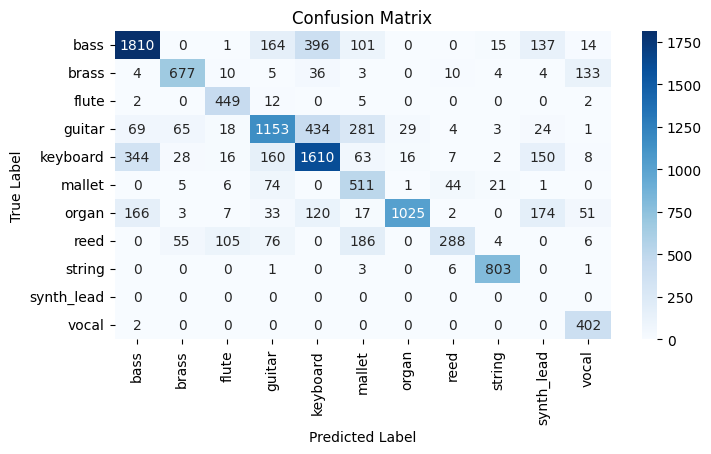

0.688436661934059

In [9]:
model1 = pickle.load(open(model_path, "rb"))
test(X_valid1, y_valid, model1)

In [10]:
# model 2: max pooling + metadata
model_path = "ML_RandomForestCLF_2.pickle"

# TODO: un-comment this line for training
model2 = train_and_evaluate(X_train2, y_train, model_path)


[Train] Top 1 Accuracy: 1.0000
[Train] Top 3 Accuracy: 1.0000
---------------


Top 1 Accuracy: 0.6495
Top 3 Accuracy: 0.8582


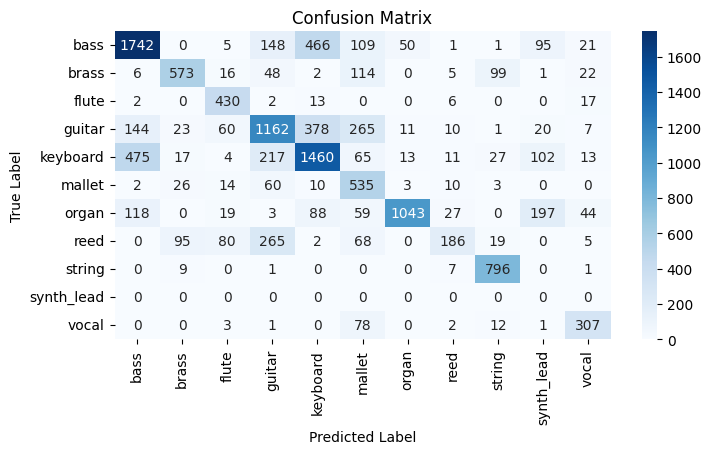

0.6494715254772047

In [11]:
model2 = pickle.load(open(model_path, "rb"))
test(X_valid2, y_valid, model2)

### Hyperparameter Tuning

In [12]:
# Grid search
n_estimators = [200, 300, 500]
max_depth = [20, 25, 30]
min_samples_split = [2, 3, 5]

cnt = 0
best_acc = 0
best_params  = {}
best_model_path = "ML_RandomForestCLF_best.pickle"
for i in n_estimators:
    for j in max_depth:
        for k in min_samples_split:
            params = {
                "n_estimators": i,
                "max_depth": j,
                "min_samples_split": k,
                "random_state": RANDOM_SEED,
                "n_jobs": -1,
            }
            cnt+=1
            print(f"{cnt} params: {params}")

            # use mean pooling features
            model = train_and_evaluate(X_train1, y_train, params=params)
            top1_acc = test(X_valid1, y_valid, model, verbose=False)
            print()

            # save model
            if top1_acc >= best_acc:
                best_params = params.copy()
                with open(best_model_path, 'wb') as f:
                    pickle.dump(model, f)


1 params: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'random_state': 0, 'n_jobs': -1}
[Train] Top 1 Accuracy: 0.9980
[Train] Top 3 Accuracy: 1.0000
---------------
Top 1 Accuracy: 0.6864
Top 3 Accuracy: 0.8963

2 params: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 3, 'random_state': 0, 'n_jobs': -1}
[Train] Top 1 Accuracy: 0.9974
[Train] Top 3 Accuracy: 1.0000
---------------
Top 1 Accuracy: 0.6828
Top 3 Accuracy: 0.8987

3 params: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'random_state': 0, 'n_jobs': -1}
[Train] Top 1 Accuracy: 0.9966
[Train] Top 3 Accuracy: 1.0000
---------------
Top 1 Accuracy: 0.6876
Top 3 Accuracy: 0.8979

4 params: {'n_estimators': 200, 'max_depth': 25, 'min_samples_split': 2, 'random_state': 0, 'n_jobs': -1}
[Train] Top 1 Accuracy: 0.9998
[Train] Top 3 Accuracy: 1.0000
---------------
Top 1 Accuracy: 0.6876
Top 3 Accuracy: 0.8991

5 params: {'n_estimators': 200, 'max_depth': 25, 'min_samples_split': 3, 'ra

Top 1 Accuracy: 0.6921
Top 3 Accuracy: 0.9027


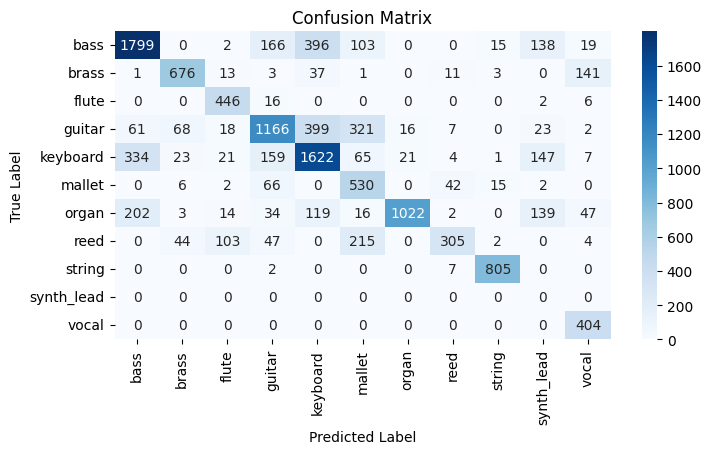

{'n_estimators': 500,
 'max_depth': 30,
 'min_samples_split': 5,
 'random_state': 0,
 'n_jobs': -1}

In [13]:
model = pickle.load(open(best_model_path, "rb"))
test(X_valid1, y_valid, model)
best_params